In [1]:
from modules import sim_spectra as simu
from modules import solve_sdos as slvsdos
from modules import solve_sdos_adv as slvadv
from scipy.sparse.linalg import lsmr as lsmr
from scipy.sparse.linalg import lsqr as lsqr
from scipy.optimize import curve_fit as curve_fit
import time
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [2]:
guess=[8e-5,1.4e-3,1.8] ; lb=[1e-6,1e-3,0.] ; ub=[5e-4,5e-3,3.]
gamma=3e-4 ; delta=2e-3 ; T=1.0
amp=.02 ; freq=3000.
iv,es=simu.sim_sdos(gamma,delta,T,-0.01,0.01,amp=amp,freq=freq)

<IPython.core.display.Javascript object>


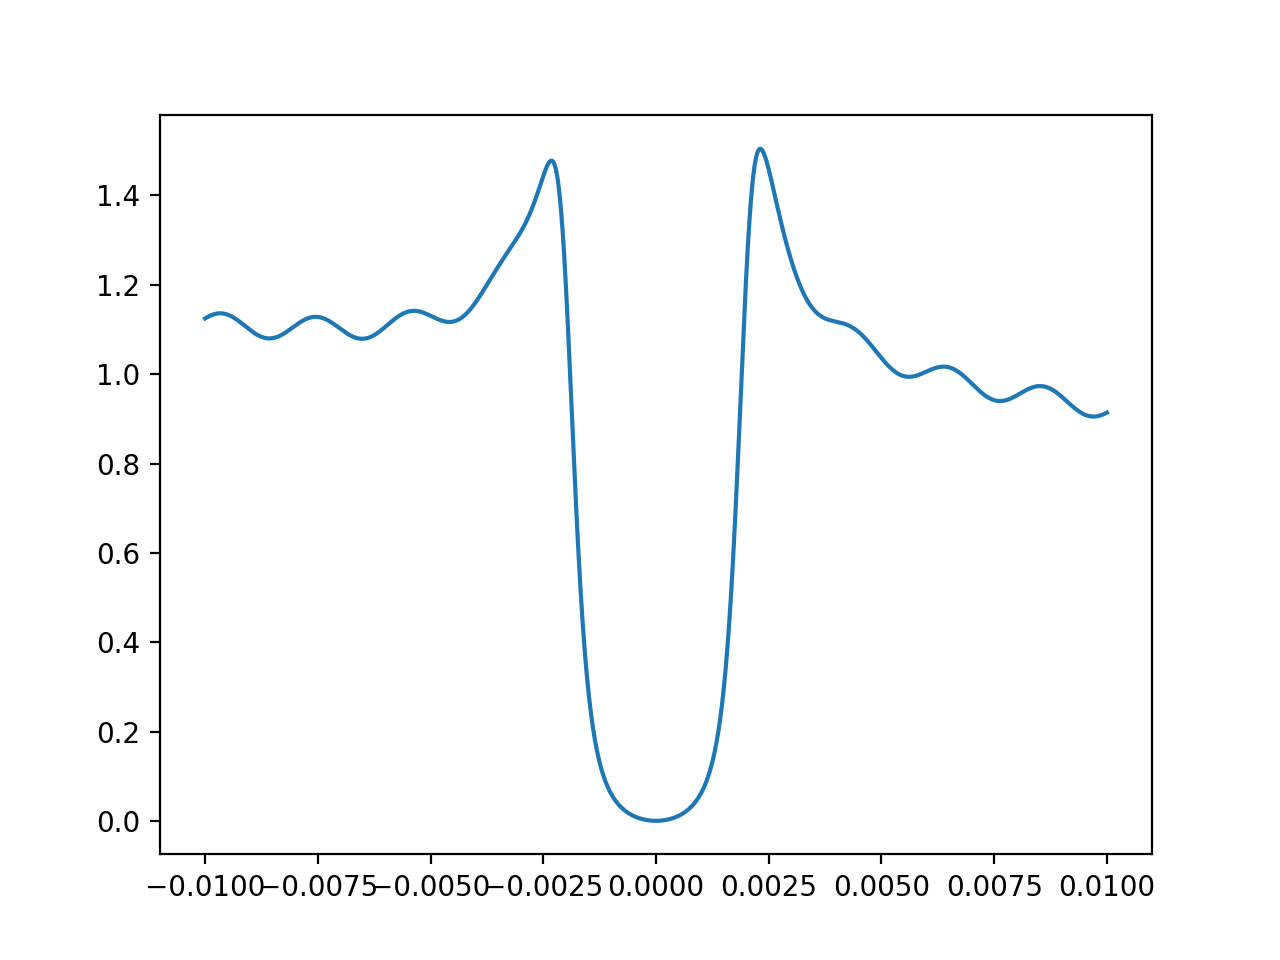

<IPython.core.display.Javascript object>


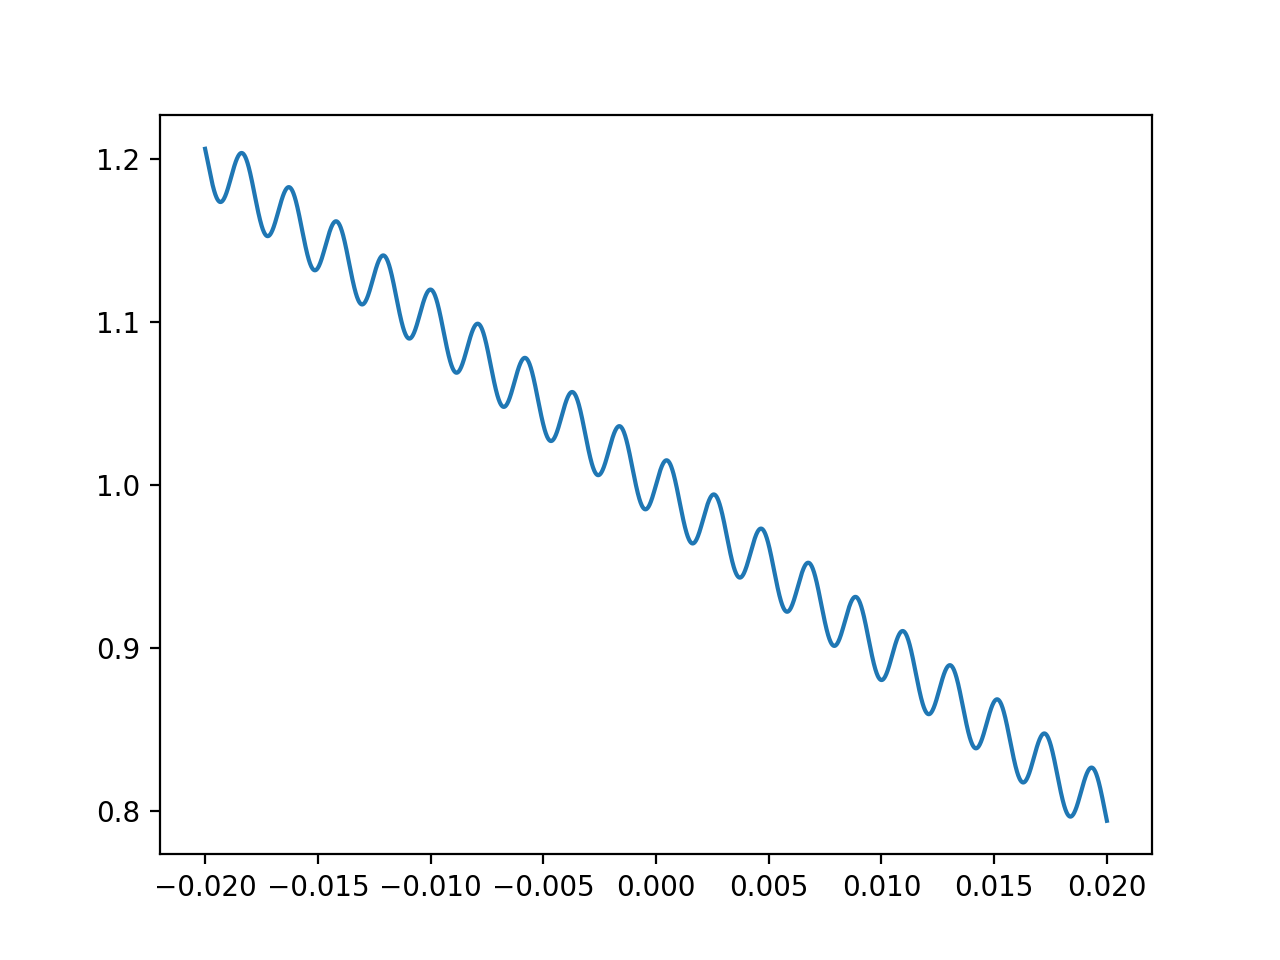

In [3]:
figure()
plot(iv[0],iv[1])

figure()
plot(es[0],es[1])

# Solving for sample density of states given exact: Gamma, Delta,T

0.566534996033
0.542408943176


<IPython.core.display.Javascript object>


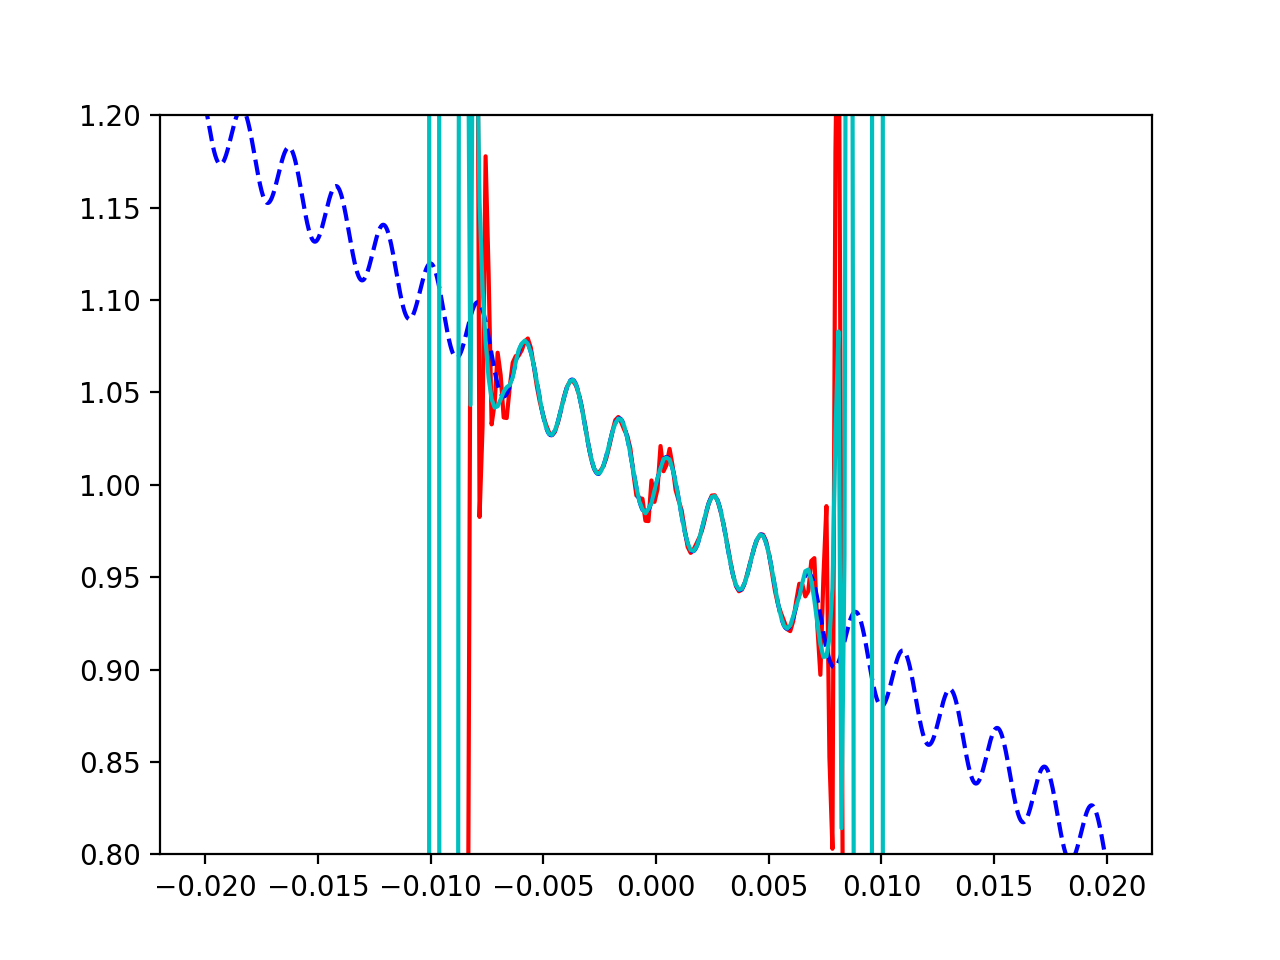

(0.8, 1.2)

In [5]:
start=time.time()
E,sdos_true=slvsdos.get_sdos(iv[0],iv[1],gamma,delta,T,E_sampling=300,rcond=1e-14)
print time.time()-start

start=time.time()
Ep,C=slvsdos.get_mat(iv[0],gamma,delta,T,E_sampling=300)
x=lsmr(C,iv[1],atol=1e-3,btol=1e-3)[0]
print time.time()-start

figure()
plot(Ep,x,"r-")
plot(es[0],es[1],"b--")
plot(E,sdos_true,"c-")
ylim(0.8,1.2)

# Solving for sample density of states given wrong guesses for: Gamma, Delta,T

<IPython.core.display.Javascript object>


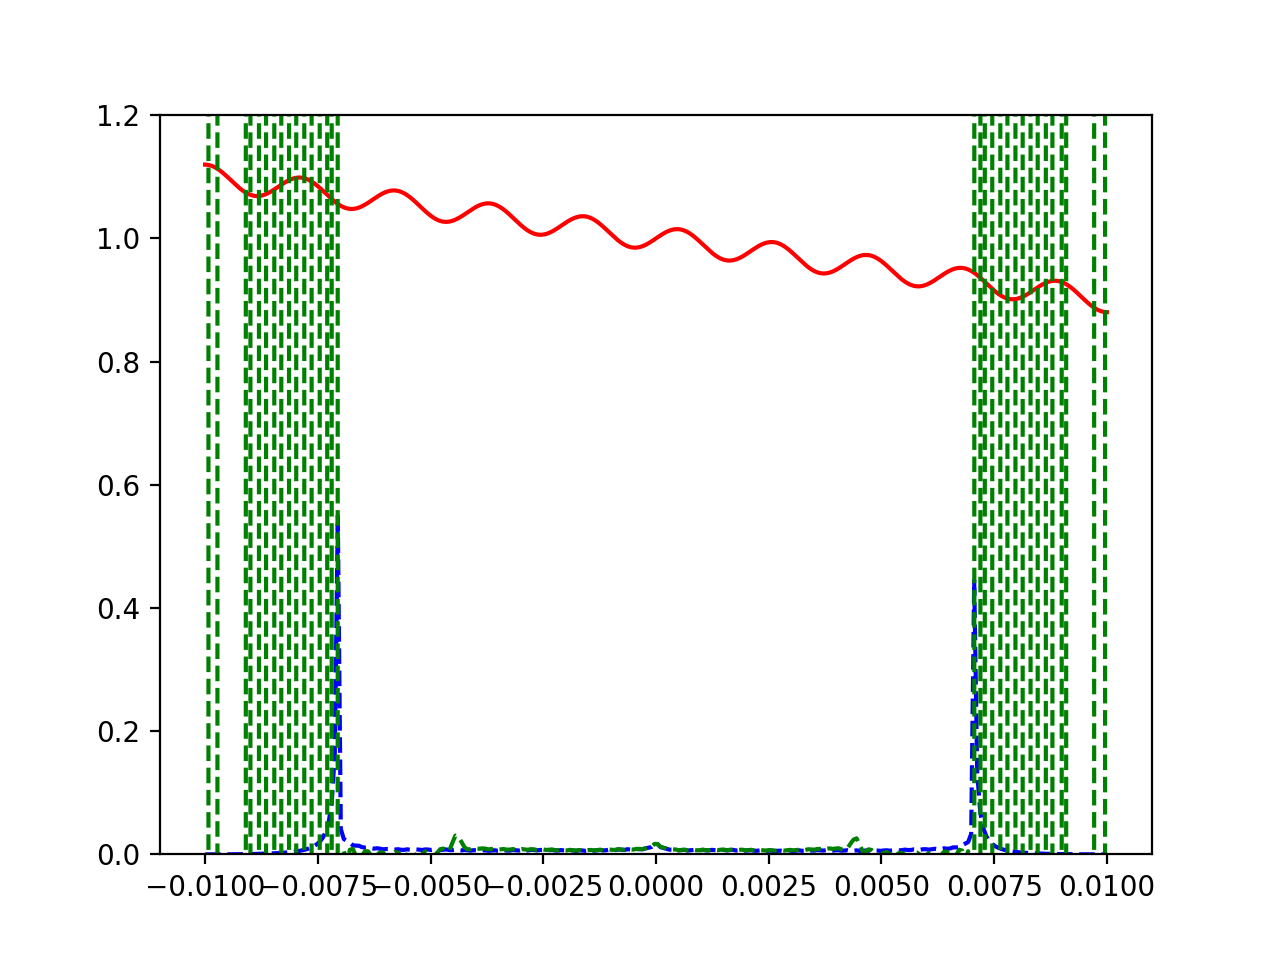

<IPython.core.display.Javascript object>


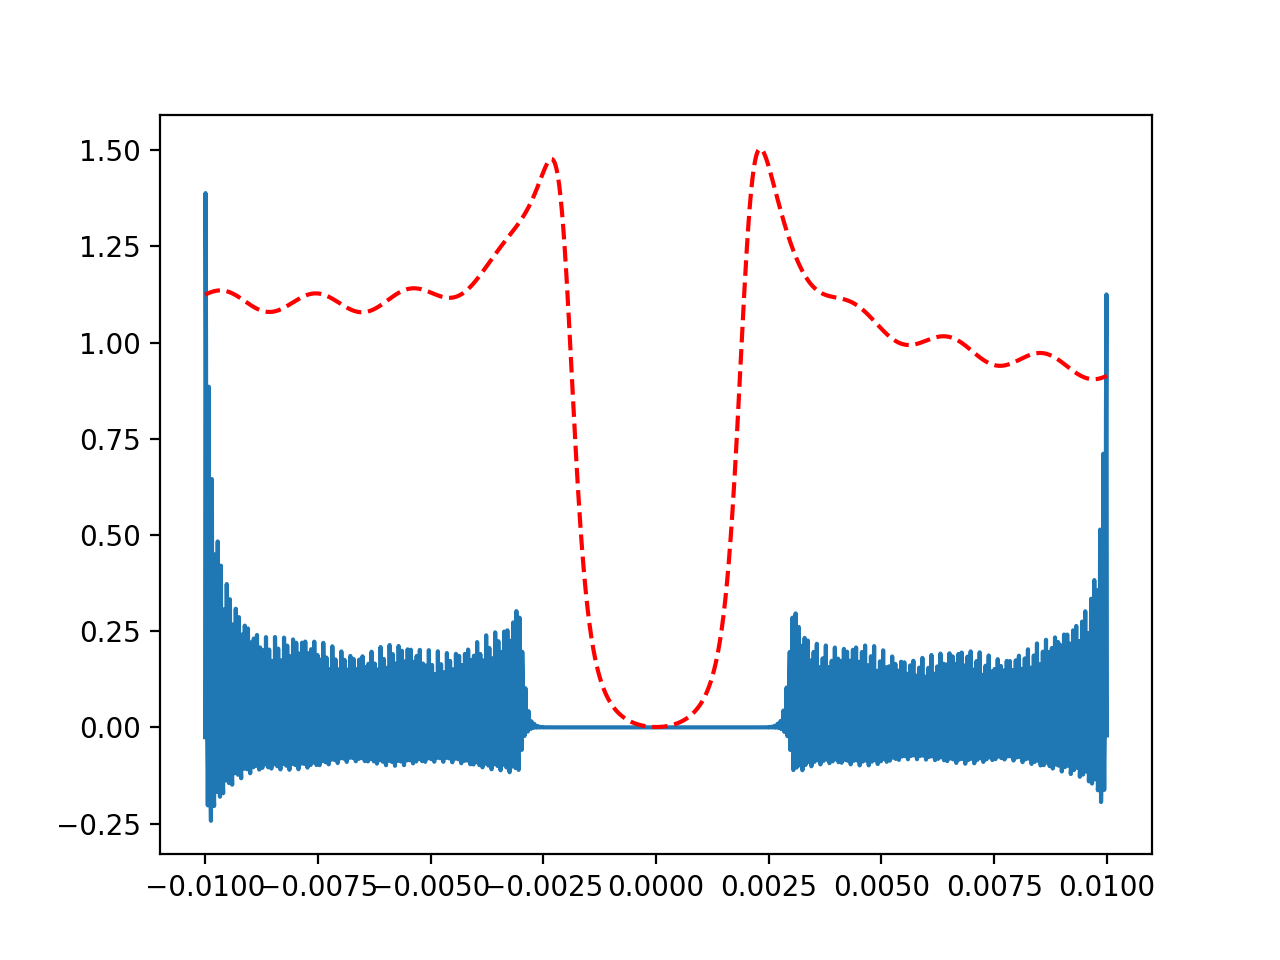

<IPython.core.display.Javascript object>


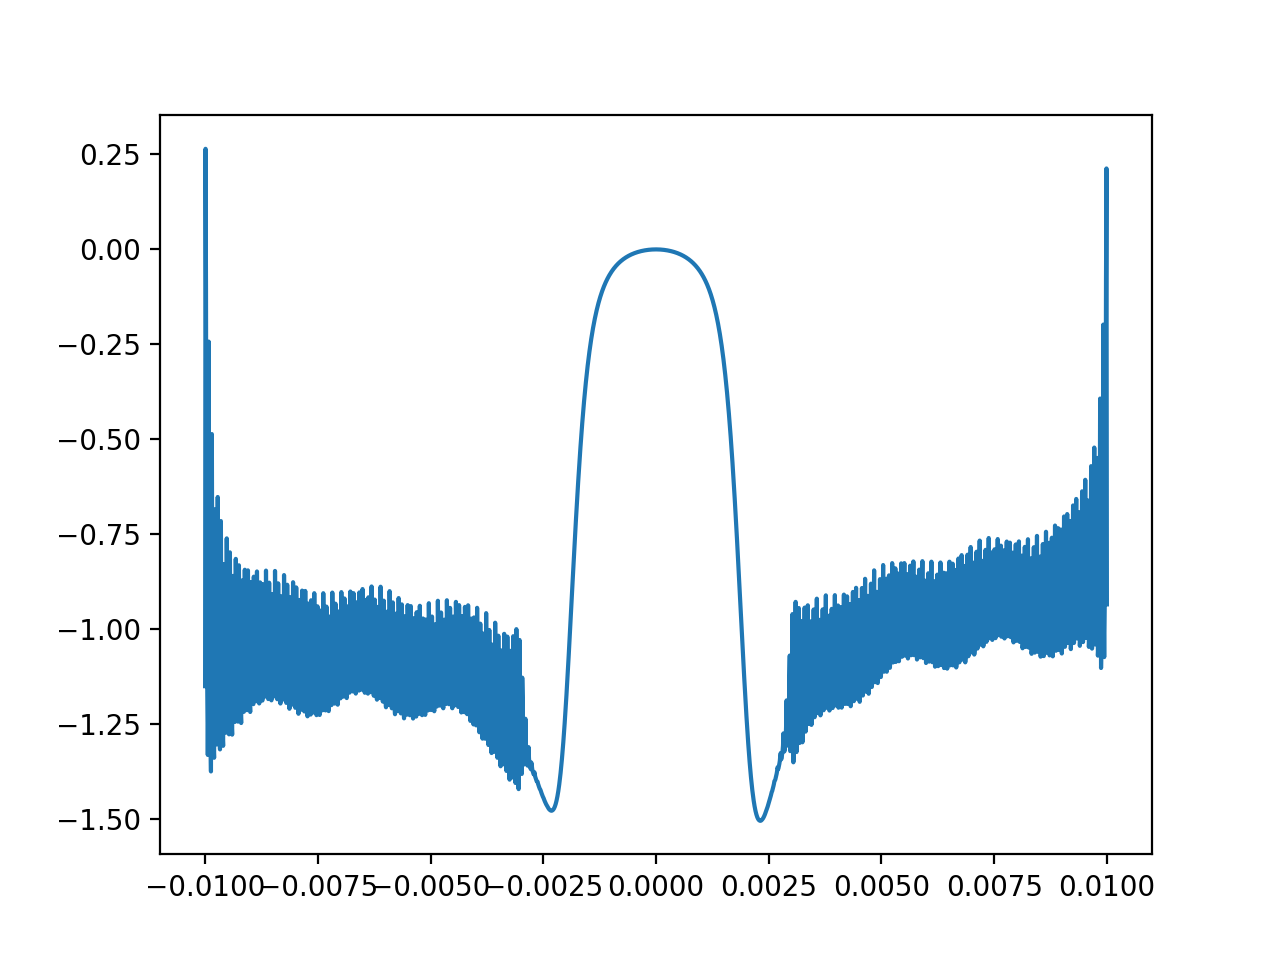

In [193]:
E,sdos_bad=slvsdos.get_sdos(iv[0],iv[1],guess[0],guess[1],guess[2],E_sampling=300,rcond=1e-14)
Ep,C=slvsdos.get_mat(iv[0],guess[0],guess[1],guess[2],E_sampling=300)
#Ep,C=slvsdos.get_mat(iv[0],gamma,delta,T,E_sampling=300)
x=lsmr(C,iv[1],atol=1e-3,btol=1e-3)[0]
rec_dIdV=np.array(C*np.transpose(np.matrix(x))).flatten()

figure()
plot(es[0],es[1],"r-")
plot(Ep,x,"b--")
plot(E,sdos_bad,"g--")
ylim(0.,1.2)


figure()
plot(iv[0],rec_dIdV)
plot(iv[0],iv[1],"r--")

figure()
plot(iv[0],rec_dIdV-iv[1])

In [128]:
def get_rec_dIdV(V, gamma, delta, T, dIdV, E_sampling=3000):
    E,C=slvsdos.get_mat(V,gamma, delta, T,E_sampling=E_sampling)
    #sdos=lsmr(C,dIdV,atol=1e-5,btol=1e-5)[0]
    sdos=lsqr(C,dIdV,atol=1e-4,btol=1e-4)[0]
    recon_dIdV=np.array(C*np.transpose(np.matrix(sdos))).flatten()
    return recon_dIdV

def get_params(V,dIdV,guess,lb,ub,err=[],E_sampling=3000):
    fn = lambda x,gamma,delta,T: get_rec_dIdV(x,gamma,delta,T,dIdV=dIdV,E_sampling=E_sampling)
    if np.size(err)==0:
        par,par_cov=curve_fit(fn,V,dIdV,p0=guess,bounds=[lb,ub])
    else:
        par,par_cov=curve_fit(fn,V,dIdV,p0=guess,bounds=[lb,ub],sigma=err)
    return par

<IPython.core.display.Javascript object>


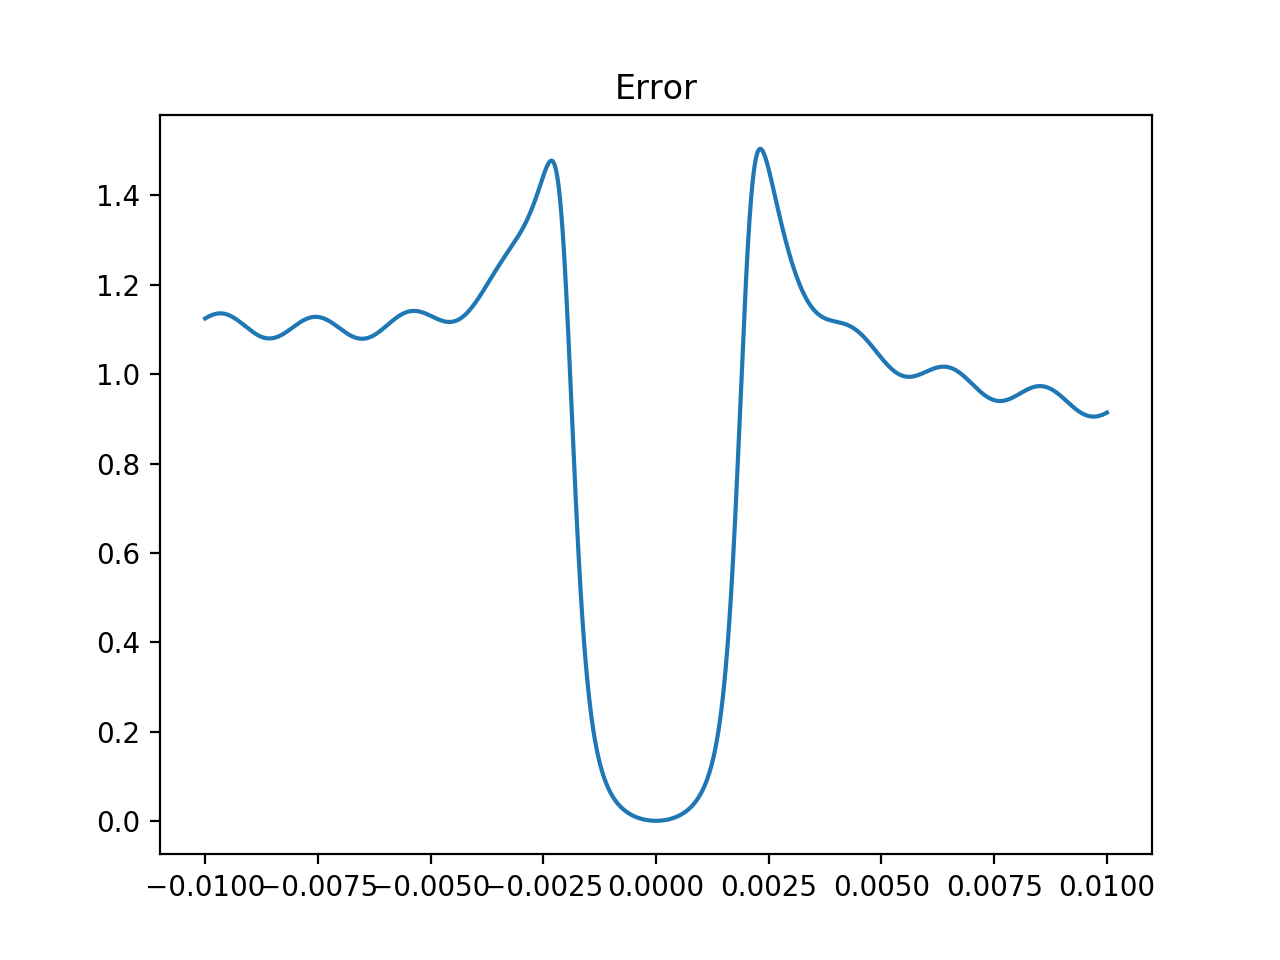

In [129]:
err=np.ones(np.size(iv[0]))
err=iv[1]
#err[abs(iv[0])>0.0025]=1.
figure()
plot(iv[0],err)
title("Error")
#semilogy()

In [132]:
guess=[1e-5,3e-3,1.]
lb=[1e-6,1e-3,0.]
ub=[5e-4,5e-3,3.]
par=get_params(iv[0],iv[1],guess,lb,ub,err=err,E_sampling=600)

Ep,C=slvsdos.get_mat(iv[0],par[0],par[1],par[2],E_sampling=600)
rec_sdos=lsmr(C,iv[1],atol=1e-3,btol=1e-3)[0]

In [133]:
par

array([  2.48878893e-04,   2.01532958e-03,   1.34401901e+00])

In [107]:
rec_sdos=lsmr(C,iv[1],atol=1e-5,btol=1e-5)[0]

<IPython.core.display.Javascript object>


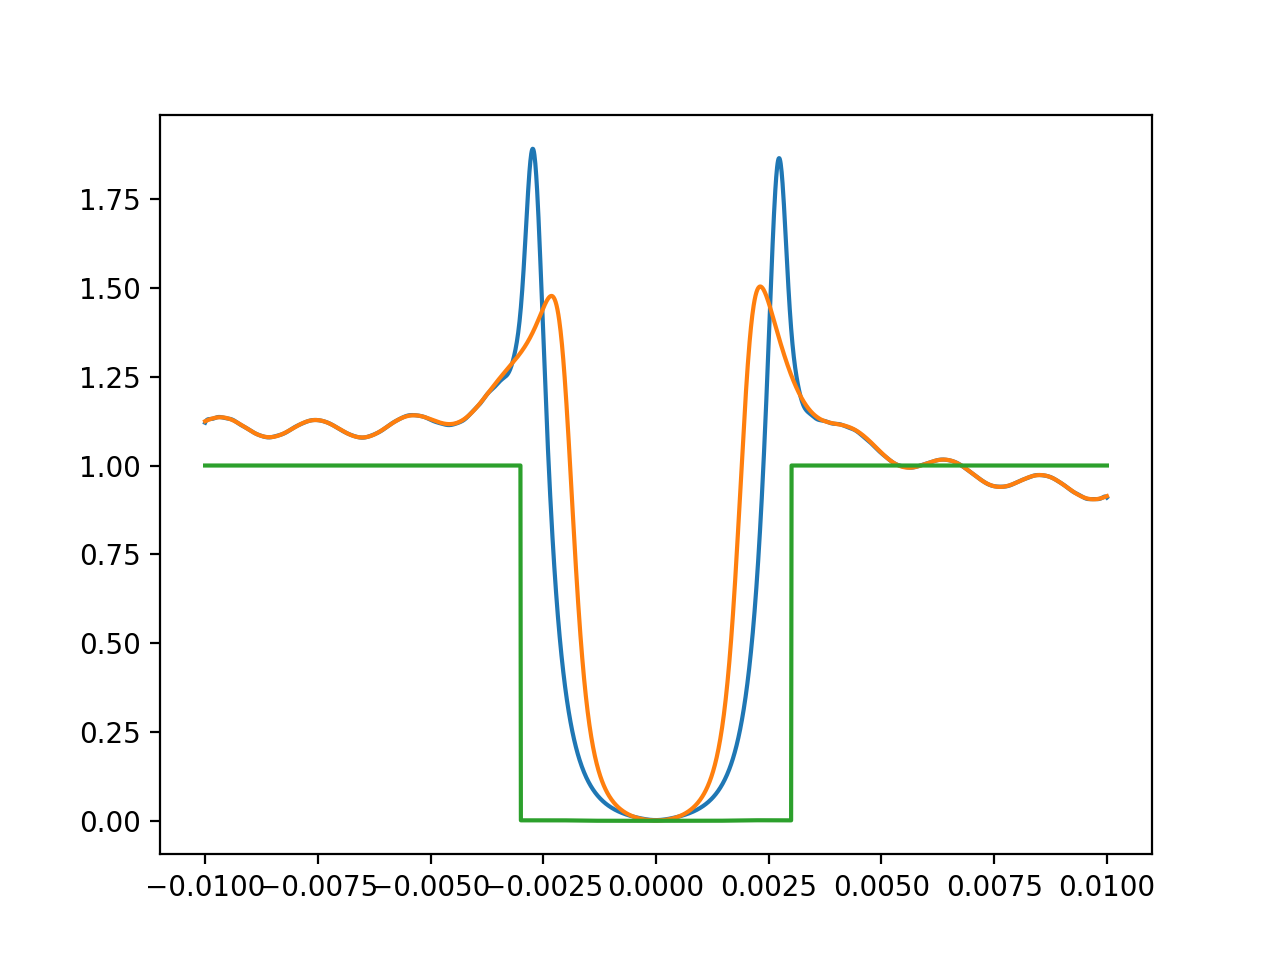

<IPython.core.display.Javascript object>


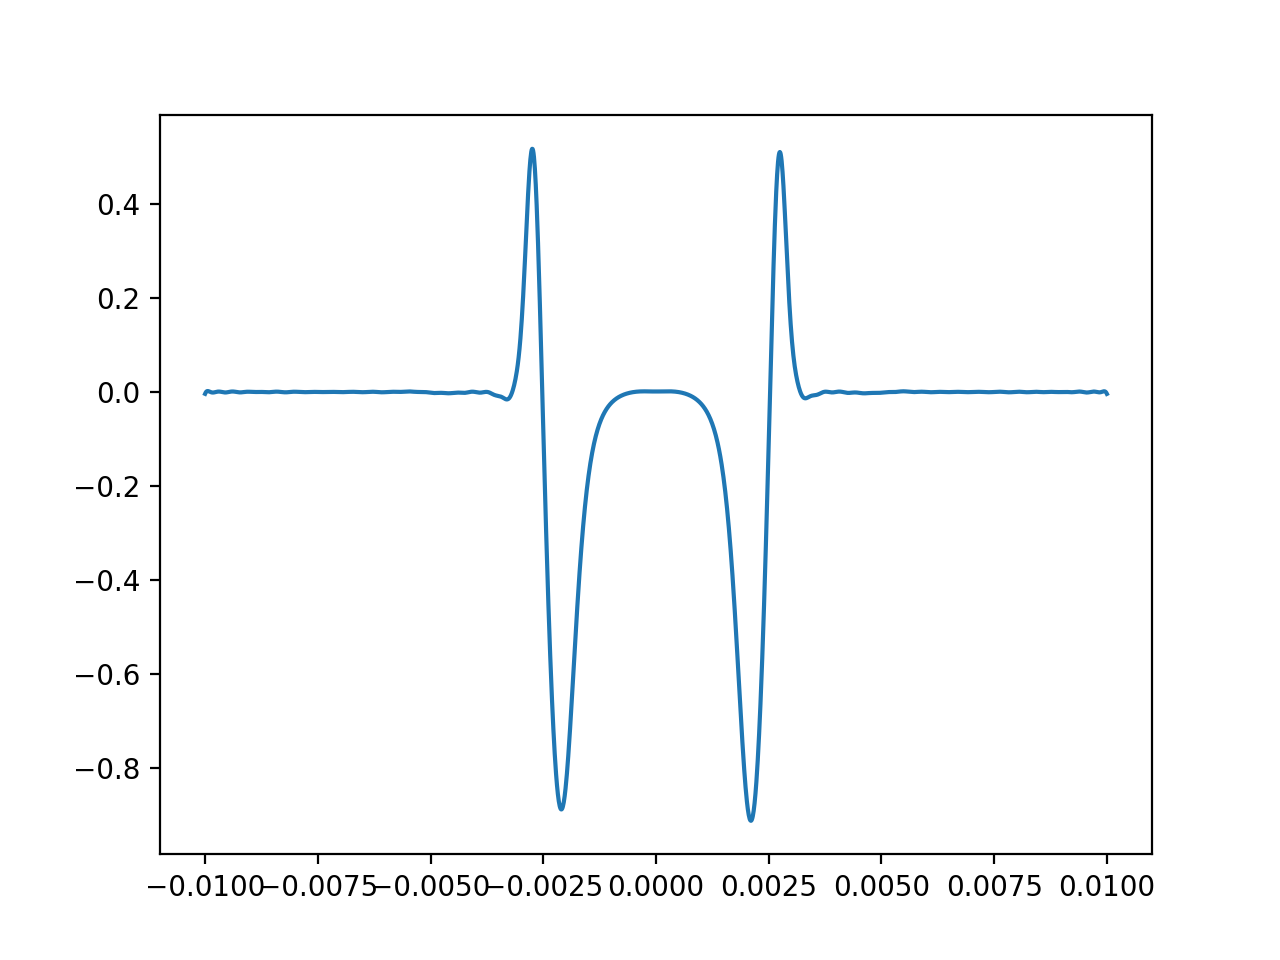

<IPython.core.display.Javascript object>


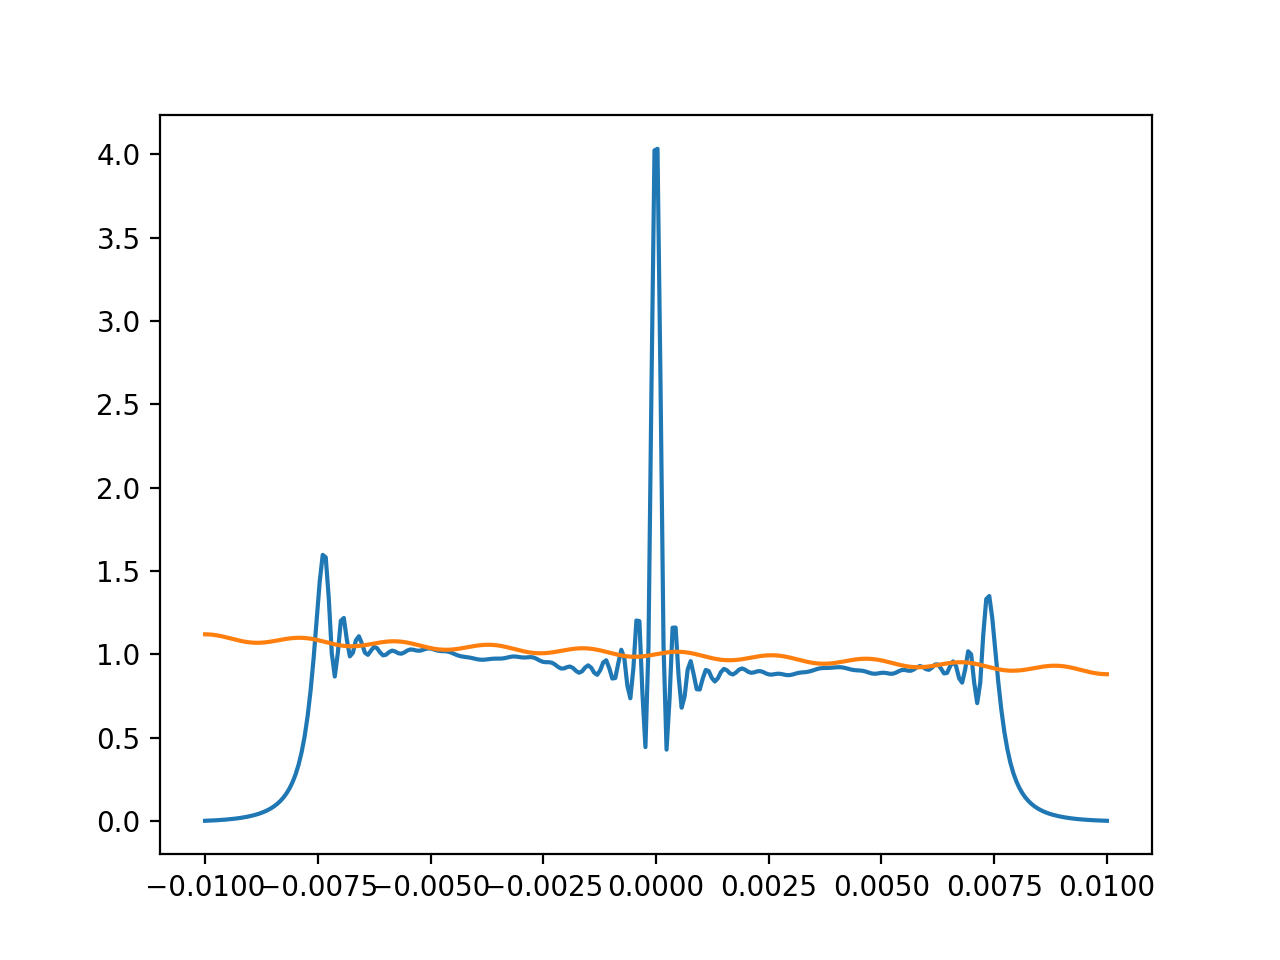

In [108]:
figure()
plot(iv[0],get_rec_dIdV(iv[0],par[0],par[1],par[2],iv[1],E_sampling=300))
plot(iv[0],iv[1])
plot(iv[0],err/max(err))

figure()
plot(iv[0],get_rec_dIdV(iv[0],par[0],par[1],par[2],iv[1],E_sampling=300)-iv[1])

figure()
plot(Ep,rec_sdos)
plot(es[0],es[1])